In [368]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Завантаження даних

In [328]:
df1 = pd.read_csv('dataset/transaction_new.csv')
df2 = pd.read_csv('dataset/output_file.csv')
df2 = df2.rename(columns={'id': 'product_id'})
df_combined_left = pd.merge(df1, df2, on='product_id', how='left')
df_combined_left.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 25 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   created_at              1254585 non-null  object 
 1   customer_id             1254585 non-null  int64  
 2   booking_id              1254585 non-null  object 
 3   session_id              1254585 non-null  object 
 4   payment_method          1254585 non-null  object 
 5   payment_status          1254585 non-null  object 
 6   promo_amount            1254585 non-null  int64  
 7   promo_code              481139 non-null   object 
 8   shipment_fee            1254585 non-null  int64  
 9   shipment_date_limit     1254585 non-null  object 
 10  shipment_location_lat   1254585 non-null  float64
 11  shipment_location_long  1254585 non-null  float64
 12  total_amount            1254585 non-null  int64  
 13  product_id              1254585 non-null  int64  
 14  qu

### Перевірка категорій

In [329]:
duplicates = df2[df2.duplicated(subset=['productDisplayName'], keep=False)]
duplicates_with_diff_subcategory = duplicates.groupby('productDisplayName').filter(lambda x: x['subCategory'].nunique() > 1)
duplicates_with_diff_subcategory
variants_for_each_product = duplicates_with_diff_subcategory.groupby('productDisplayName')['subCategory'].unique()
variants_for_each_product

productDisplayName
Aspen Women Black Dial Watch                                 [Free Gifts, Watches]
Aspen Women White Dial Watch                                 [Watches, Free Gifts]
Baggit Women Purple Wallet                                         [Wallets, Bags]
Clarks Men Black Leather Sandals                                   [Shoes, Sandal]
Clarks Men Brown Leather Sandals                                   [Sandal, Shoes]
Cobblerz Women Brown Sandals                                       [Shoes, Sandal]
Ferrari Men Perfume                                          [Fragrance, Perfumes]
Franco Leone Men Casual Black Sandals                              [Sandal, Shoes]
Franco Leone Men Casual Brown Sandals                              [Sandal, Shoes]
Giordano Men Black Dial Watch                                [Watches, Free Gifts]
Giordano Women White Dial Watch                              [Free Gifts, Watches]
Hanes Men Pack of 2 Half Contrast Piping Ringer T-shirts      [Inner

### Відбір трназакцій

In [330]:
booking_counts = df_combined_left['booking_id'].value_counts()

frequent_bookings =  booking_counts[(booking_counts > 1)].index
df_frequent_bookings = df_combined_left[df_combined_left['booking_id'].isin(frequent_bookings)]
df_frequent_bookings.reset_index(drop=True, inplace=True)
df_frequent_bookings = df_frequent_bookings.rename(columns={'booking_id': 'transactions', 'subCategory':'product_сategory'})

df = df_frequent_bookings[['transactions', 'product_сategory', 'quantity', 'payment_status']]
df = df[df['payment_status'] == 'Success']  
df.drop(columns=['payment_status'], inplace=True)
df

,transactions,product_сategory,quantity
0,771665e9-7df2-41c8-8168-16d5cdd407a1,Saree,1
1,771665e9-7df2-41c8-8168-16d5cdd407a1,Topwear,1
2,771665e9-7df2-41c8-8168-16d5cdd407a1,Sandal,1
3,771665e9-7df2-41c8-8168-16d5cdd407a1,Shoes,1
4,771665e9-7df2-41c8-8168-16d5cdd407a1,Shoes,1
...,...,...,...
547912,98206a95-8095-45ec-90fe-701df7b1b654,Topwear,1
547913,bb64c193-bc69-4190-bc36-cb601651e506,Topwear,1
547914,bb64c193-bc69-4190-bc36-cb601651e506,Topwear,5
547915,e3877a13-8283-4b71-adb6-55e22ca62247,Shoes,1


In [331]:
frequent_bookings =  booking_counts[(booking_counts <= 1)].index
len(frequent_bookings)

706668

In [332]:
category_transaction_counts = df.groupby('product_сategory')['transactions'].nunique().reset_index()
category_transaction_counts.columns = ['product_сategory', 'transaction_count']

unique_categories = category_transaction_counts['product_сategory'].unique()
print(unique_categories)

['Accessories' 'Apparel Set' 'Bags' 'Bath and Body' 'Beauty Accessories'
 'Belts' 'Bottomwear' 'Cufflinks' 'Dress' 'Eyes' 'Eyewear' 'Flip Flops'
 'Fragrance' 'Free Gifts' 'Gloves' 'Hair' 'Headwear' 'Home Furnishing'
 'Innerwear' 'Jewellery' 'Lips' 'Loungewear and Nightwear' 'Makeup'
 'Mufflers' 'Nails' 'Perfumes' 'Sandal' 'Saree' 'Scarves'
 'Shoe Accessories' 'Shoes' 'Skin' 'Skin Care' 'Socks'
 'Sports Accessories' 'Sports Equipment' 'Stoles' 'Ties' 'Topwear'
 'Umbrellas' 'Vouchers' 'Wallets' 'Watches' 'Water Bottle' 'Wristbands']


### Візалізація співвідношення категорій у транзакційях

In [333]:
import plotly.express as px
%matplotlib inline

threshold = 2954
category_transaction_counts['product_сategory'] = category_transaction_counts.apply(
    lambda row: row['product_сategory'] if row['transaction_count'] >= threshold else 'Other', axis=1
)

category_transaction_counts = category_transaction_counts.groupby('product_сategory').agg({
    'transaction_count': 'sum'
}).reset_index()

fig = px.treemap(
    category_transaction_counts, 
    path=['product_сategory'], 
    values='transaction_count',
    title='Кількість транзакцій для кожної категорії продуктів',
    labels={'transaction_count': 'Кількість транзакцій', 'product_category': 'Категорія продукту'}
)

fig.update_traces(root_color="lightgrey", texttemplate="%{label}<br>%{value}<br>%{percentParent:.2%}")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()

C:\Users\Kira\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Kira\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Візалізація співвідношення категорій у всіх продуктах

In [334]:
category_counts = df2.groupby('subCategory').size().reset_index(name='count')

threshold = 150
category_counts['subCategory'] = category_counts.apply(
    lambda row: row['subCategory'] if row['count'] >= threshold else 'Other', axis=1
)

category_transaction_counts = category_counts.groupby('subCategory').agg({
    'count': 'sum'
}).reset_index()

fig = px.treemap(
    category_counts, 
    path=['subCategory'], 
    values='count',
    title='Кількість продуктів у кожній категорії',
    labels={'count': 'Кількість транзакцій', 'subCategory': 'Категорія продукту'}
)

fig.update_traces(root_color="lightgrey", texttemplate="%{label}<br>%{value}<br>%{percentParent:.2%}")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()

C:\Users\Kira\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Kira\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Побудова розподілів транзкацій за роками до та після відбору

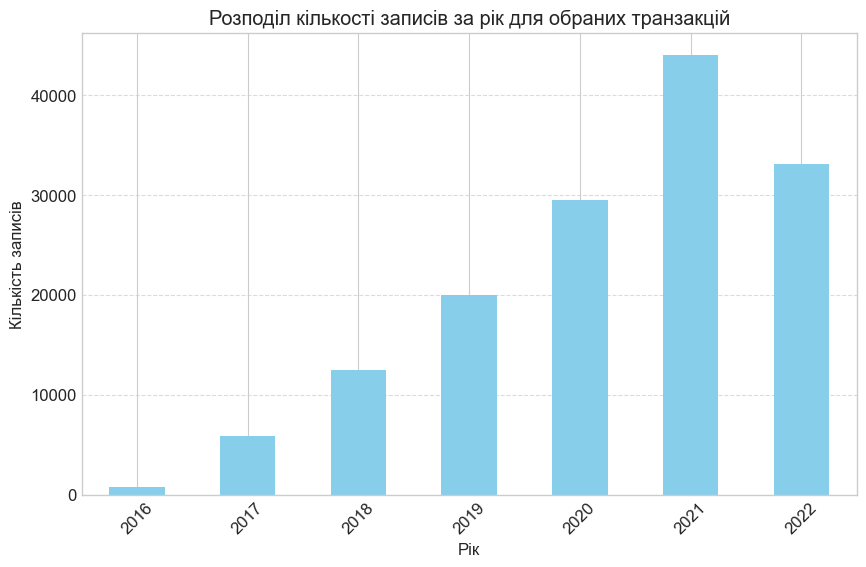

In [335]:
import matplotlib.pyplot as plt

df_frequent_bookings = df_frequent_bookings.drop_duplicates(subset=['transactions'])
df_frequent_bookings['created_at'] = pd.to_datetime(df_frequent_bookings['created_at'])
data_grouped_frequent = df_frequent_bookings.groupby(df_frequent_bookings['created_at'].dt.year).size()


plt.figure(figsize=(10, 6))
data_grouped_frequent.plot(kind='bar', color='skyblue')
plt.title('Розподіл кількості записів за рік для обраних транзакцій')
plt.xlabel('Рік')
plt.ylabel('Кількість записів')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

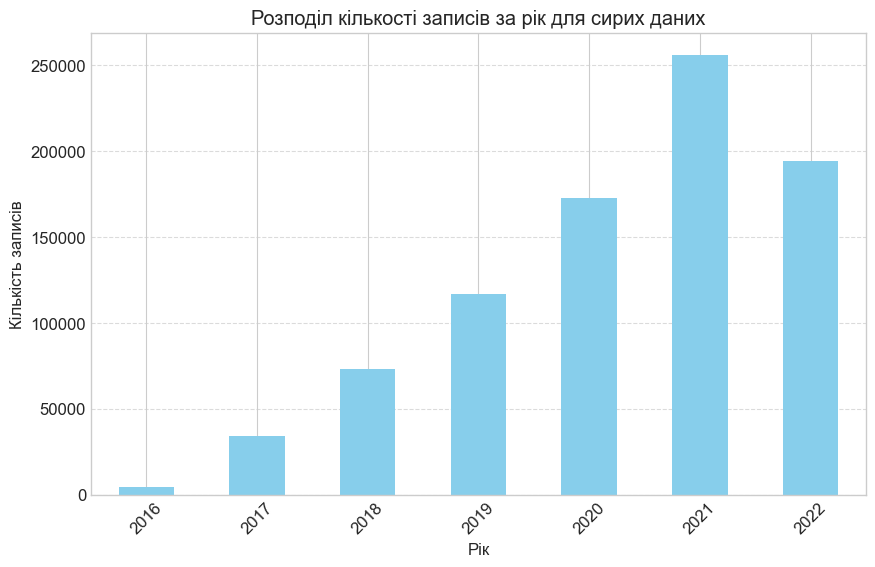

In [336]:
df1 = df1.drop_duplicates(subset=['booking_id'])
df1['created_at'] = pd.to_datetime(df1['created_at'])
data_grouped_raw = df1.groupby(df1['created_at'].dt.year).size()

plt.figure(figsize=(10, 6))
data_grouped_raw.plot(kind='bar', color='skyblue')
plt.title('Розподіл кількості записів за рік для сирих даних')
plt.xlabel('Рік')
plt.ylabel('Кількість записів')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



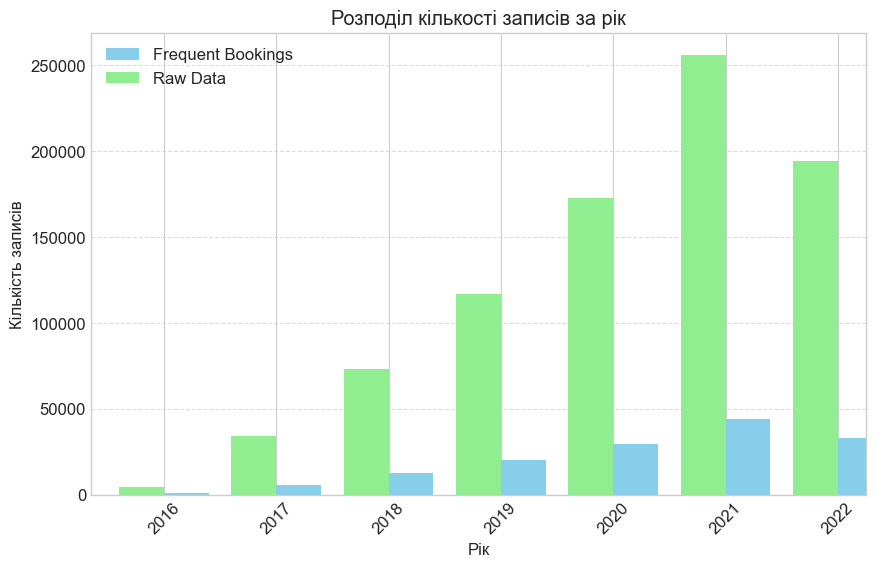

In [337]:
plt.figure(figsize=(10, 6))
data_grouped_frequent.plot(kind='bar', color='skyblue', position=0, width=0.4, label='Frequent Bookings')
data_grouped_raw.plot(kind='bar', color='lightgreen', position=1, width=0.4, label='Raw Data')
plt.title('Розподіл кількості записів за рік')
plt.xlabel('Рік')
plt.ylabel('Кількість записів')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Формування датасету для Апріорі

In [338]:
le = LabelEncoder().fit(df['transactions'])
df['transactions'] = le.transform(df['transactions'])
df

C:\Users\Kira\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Kira\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Kira\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Kira\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



,transactions,product_сategory,quantity
0,65086,Saree,1
1,65086,Topwear,1
2,65086,Sandal,1
3,65086,Shoes,1
4,65086,Shoes,1
...,...,...,...
547912,83068,Topwear,1
547913,102277,Topwear,1
547914,102277,Topwear,5
547915,124236,Shoes,1


In [339]:
subset_df = df.groupby(['transactions', 'product_сategory'])['quantity'].sum()
subset_df = subset_df.unstack().reset_index()
subset_df.head()

product_сategory,transactions,Accessories,Apparel Set,Bags,Bath and Body,Beauty Accessories,Belts,Bottomwear,Cufflinks,Dress,...,Sports Equipment,Stoles,Ties,Topwear,Umbrellas,Vouchers,Wallets,Watches,Water Bottle,Wristbands
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
subset_df = subset_df.fillna(0).astype('int32')
subset_df = subset_df.set_index('transactions')
subset_df.head()

product_сategory,Accessories,Apparel Set,Bags,Bath and Body,Beauty Accessories,Belts,Bottomwear,Cufflinks,Dress,Eyes,...,Sports Equipment,Stoles,Ties,Topwear,Umbrellas,Vouchers,Wallets,Watches,Water Bottle,Wristbands
transactions,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0


In [341]:
def hot_encode(x):
    if(x<= 0):
        return False
    else:
        return True

subset_df = subset_df.applymap(hot_encode)
subset_df.head()

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\878555073.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



product_сategory,Accessories,Apparel Set,Bags,Bath and Body,Beauty Accessories,Belts,Bottomwear,Cufflinks,Dress,Eyes,...,Sports Equipment,Stoles,Ties,Topwear,Umbrellas,Vouchers,Wallets,Watches,Water Bottle,Wristbands
transactions,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


###  Застостування Апріорі

In [342]:
from mlxtend.frequent_patterns import apriori, association_rules
apriori_items = apriori(subset_df, min_support=0.009, use_colnames=True)
apriori_items.sort_values(['support'], ascending=[False])
print(apriori_items.count()['itemsets'])
apriori_items

226


,support,itemsets
0,0.011786,(Accessories)
1,0.009029,(Apparel Set)
2,0.221459,(Bags)
3,0.066726,(Belts)
4,0.198346,(Bottomwear)
...,...,...
221,0.009409,"(Watches, Shoes, Eyewear, Topwear)"
222,0.009609,"(Watches, Shoes, Fragrance, Topwear)"
223,0.015552,"(Watches, Shoes, Innerwear, Topwear)"
224,0.010203,"(Watches, Shoes, Jewellery, Topwear)"


In [343]:
def dependence_rules (rules_list, lable_x, function):
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize']=5,5 
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['lines.linewidth'] = 2
    sns.lineplot(x=np.linspace(0,4,20),
                 y=rules_list,
                 marker='o')
    plt.title(f" {function} with a support level of 0,9%")
    plt.xlabel(lable_x)
    plt.ylabel('nr of rules')

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\675168640.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\K

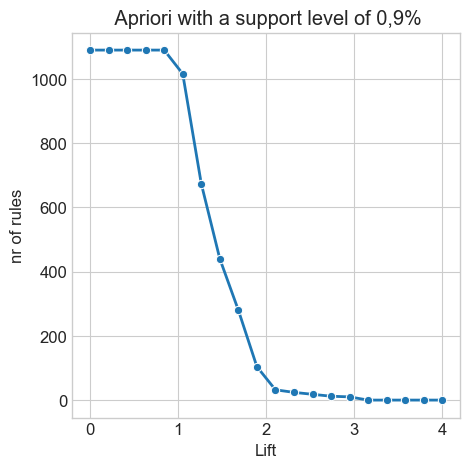

In [344]:
rules_plot_lift = []
for conf in np.linspace(0,4,20):
    rules = association_rules(apriori_items, metric="lift", min_threshold=conf)
    rules_plot_lift.append(len(rules))
dependence_rules(rules_plot_lift, 'Lift', 'Apriori')    


C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\675168640.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\K

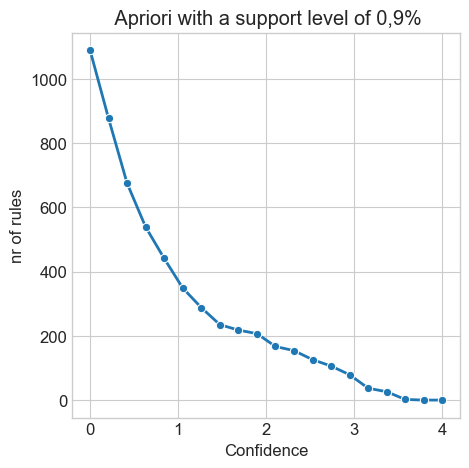

In [345]:
rules_plot_conf = []
for conf in np.linspace(0,1,20):
    rules = association_rules(apriori_items, metric="confidence", min_threshold=conf)
    rules_plot_conf.append(len(rules))
dependence_rules(rules_plot_conf, 'Confidence', 'Apriori') 

###  Формування правил та їх обробка

In [346]:
rules=association_rules(apriori_items, metric='lift', min_threshold=2)
rules['pair'] = list(zip(rules['antecedents'], rules['consequents']))
rules['pair'] = rules['pair'].apply(frozenset)
rules.drop_duplicates(subset=['pair'], keep='first', inplace=True)

rules.reset_index(drop=True, inplace=True)
rules.sort_values(['conviction'], ascending=[False]).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,pair
15,"(Watches, Bottomwear, Bags)","(Shoes, Topwear)",0.014492,0.299327,0.009759,0.673419,2.249777,0.005421,2.145480,0.563681,"((Shoes, Topwear), (Watches, Bottomwear, Bags))"
13,"(Watches, Shoes, Bottomwear, Topwear)",(Bags),0.021638,0.221459,0.009759,0.451026,2.036609,0.004967,1.418174,0.520245,"((Watches, Shoes, Bottomwear, Topwear), (Bags))"
18,"(Watches, Shoes, Bottomwear)","(Bags, Topwear)",0.024753,0.151769,0.009759,0.394272,2.597853,0.006003,1.400351,0.630678,"((Watches, Shoes, Bottomwear), (Bags, Topwear))"
14,"(Watches, Shoes, Bags, Topwear)",(Bottomwear),0.023407,0.198346,0.009759,0.416947,2.102120,0.005117,1.374925,0.536856,"((Bottomwear), (Watches, Shoes, Bags, Topwear))"
21,"(Watches, Shoes, Bags)","(Bottomwear, Topwear)",0.026923,0.136811,0.009759,0.362500,2.649644,0.006076,1.354022,0.639816,"((Bottomwear, Topwear), (Watches, Shoes, Bags))"
12,"(Shoes, Bottomwear, Topwear, Bags)",(Watches),0.024918,0.188357,0.009759,0.391667,2.079380,0.005066,1.334207,0.532352,"((Shoes, Bottomwear, Topwear, Bags), (Watches))"
16,"(Shoes, Bottomwear, Bags)","(Watches, Topwear)",0.028469,0.130195,0.009759,0.342807,2.633031,0.006053,1.323515,0.638384,"((Watches, Topwear), (Shoes, Bottomwear, Bags))"
19,"(Watches, Bottomwear, Topwear)","(Shoes, Bags)",0.032937,0.102649,0.009759,0.296304,2.886570,0.006378,1.275197,0.675828,"((Shoes, Bags), (Watches, Bottomwear, Topwear))"
22,"(Watches, Bags, Topwear)","(Shoes, Bottomwear)",0.035601,0.091508,0.009759,0.274135,2.995752,0.006502,1.251599,0.690787,"((Shoes, Bottomwear), (Watches, Bags, Topwear))"
0,"(Innerwear, Bottomwear)","(Bags, Topwear)",0.032071,0.151769,0.010311,0.321500,2.118359,0.005443,1.250157,0.545429,"((Innerwear, Bottomwear), (Bags, Topwear))"


In [347]:
rules.shape

(25, 11)

In [348]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_len"] = rules["consequents"].apply(lambda x: len(x))
rules['rule'] = rules.index
rules.drop(['antecedent support','consequent support','conviction', 'zhangs_metric', 'pair'],axis=1).sort_values(by=['lift'], ascending=False).head(100)

,antecedents,consequents,support,confidence,lift,leverage,antecedent_len,consequent_len,rule
20,"(Shoes, Bottomwear, Topwear)","(Watches, Bags)",0.009759,0.143898,3.121585,0.006633,3,2,20
24,"(Watches, Shoes, Topwear)","(Bottomwear, Bags)",0.009759,0.152239,3.087680,0.006599,3,2,24
23,"(Shoes, Bags, Topwear)","(Watches, Bottomwear)",0.009759,0.130343,3.068737,0.006579,3,2,23
22,"(Watches, Bags, Topwear)","(Shoes, Bottomwear)",0.009759,0.274135,2.995752,0.006502,3,2,22
17,"(Bottomwear, Topwear, Bags)","(Watches, Shoes)",0.009759,0.258536,2.968357,0.006472,3,2,17
19,"(Watches, Bottomwear, Topwear)","(Shoes, Bags)",0.009759,0.296304,2.886570,0.006378,3,2,19
21,"(Watches, Shoes, Bags)","(Bottomwear, Topwear)",0.009759,0.362500,2.649644,0.006076,3,2,21
16,"(Shoes, Bottomwear, Bags)","(Watches, Topwear)",0.009759,0.342807,2.633031,0.006053,3,2,16
18,"(Watches, Shoes, Bottomwear)","(Bags, Topwear)",0.009759,0.394272,2.597853,0.006003,3,2,18
4,"(Watches, Bags)","(Shoes, Bottomwear)",0.010461,0.226934,2.479936,0.006243,2,2,4


### Візуалзація отриманих правил

In [349]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo
from pandas.plotting import parallel_coordinates
%matplotlib inline


In [350]:
def line_plt(rules_g):
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize']=8,8 
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 8
    plt.rcParams['lines.linewidth'] = 3

    rules_g['antecedent'] = rules_g['antecedents'].apply(lambda antecedent: str(list(antecedent)))
    rules_g['consequent'] = rules_g['consequents'].apply(lambda consequent: str(list(consequent)))
    coords = rules_g[['antecedent','consequent','rule']]

    parallel_coordinates(coords,'rule')
    plt.show()

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\1096723312.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



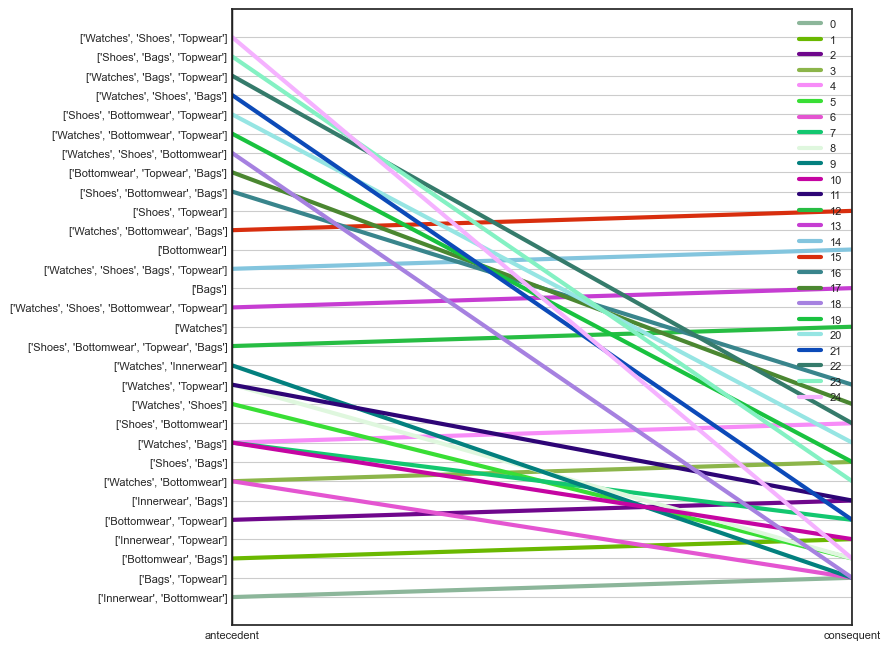

In [351]:
line_plt(rules)

C:\Users\Kira\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



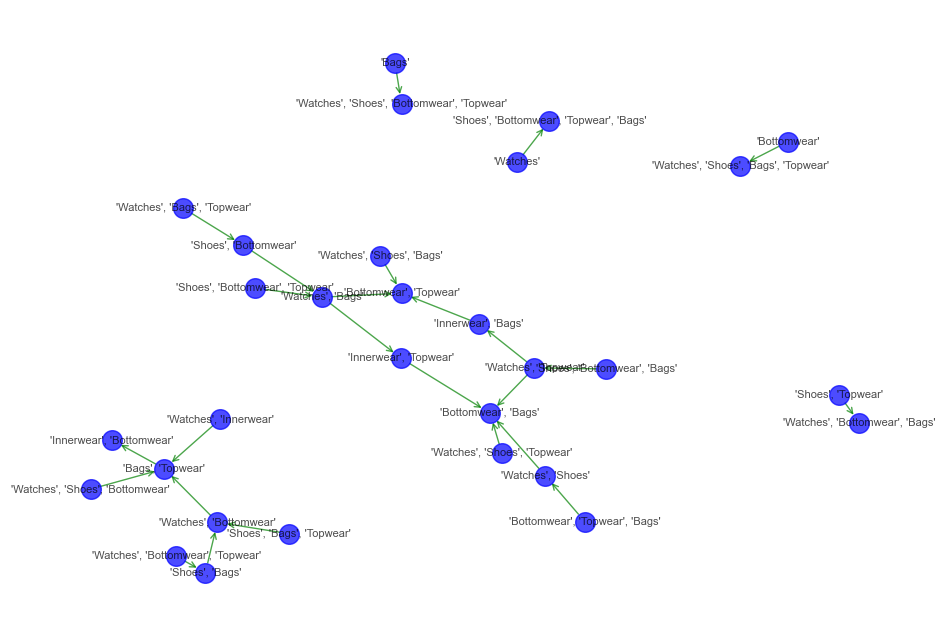

In [352]:
G = nx.from_pandas_edgelist(rules, source='antecedent', target='consequent')
plt.figure(figsize=(12, 8)) 

def remove_brackets(label):
    return ', '.join(label[1:-1].split(', '))

node_labels = {node: remove_brackets(node) for node in G.nodes()}
nx.draw_networkx(G, nx.spring_layout(G, k=0.3), arrows=True, arrowstyle='<-', labels=node_labels, cmap='cividis', alpha=0.7, 
                 edge_color='green',  font_size=8,  node_color='blue',  node_size=200)

plt.axis('off') 
plt.show()

### Підготовка даних для eclat

In [353]:
transactions = df.groupby('transactions')['product_сategory'].apply(list).tolist()
df_eclat = pd.DataFrame(transactions)
df_eclat

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,Topwear,Topwear,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Topwear,Topwear,Shoes,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Socks,Topwear,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Topwear,Bags,Topwear,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Topwear,Eyewear,Shoes,Lips,Shoes,Topwear,Topwear,Shoes,Beauty Accessories,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139655,Topwear,Bags,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
139656,Makeup,Bottomwear,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
139657,Watches,Fragrance,Topwear,Topwear,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
139658,Topwear,Ties,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [354]:
from pyECLAT import ECLAT
eclat = ECLAT(data=df_eclat)
eclat.df_bin

,Flip Flops,Watches,Shoes,Loungewear and Nightwear,Saree,Fragrance,Gloves,Dress,Wristbands,Wallets,...,Headwear,Accessories,None,Skin,Eyewear,Hair,Sandal,Nails,Beauty Accessories,Lips
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139657,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
rule_indices, rule_supports = eclat.fit_all(min_support=0.009, min_combination=1, separator=' & ', verbose=True)

Combination 1 by 1


25it [00:01, 16.63it/s]


Combination 2 by 2


300it [00:09, 32.24it/s]


Combination 3 by 3


2300it [00:54, 42.03it/s]


Combination 4 by 4


12650it [04:55, 42.75it/s]


Combination 5 by 5


53130it [23:33, 37.58it/s]


Stopping in combination 5 by 5. All supports = 0.


In [356]:
def format_data(itemsets, support):
    formatted_data = []
    for key, value in itemsets.items():
        if '&' in key:
            items = key.split(' & ')
            formatted_itemset = ', '.join(items)
        else:
            formatted_itemset = key
        formatted_data.append((value, formatted_itemset))
    return formatted_data

formatted_data = format_data(rule_supports, rule_supports)

items_ec = pd.DataFrame(formatted_data, columns=['support', 'itemsets'])
items_ec['itemsets'] = items_ec['itemsets'].apply(lambda x: frozenset(x.split(', ')))

items_ec.sort_values(by=['support'], ascending=False)

,support,itemsets
16,0.710683,(Topwear)
2,0.444959,(Shoes)
55,0.299327,"(Shoes, Topwear)"
18,0.221459,(Bags)
11,0.198346,(Bottomwear)
...,...,...
168,0.009237,"(Shoes, Topwear, Makeup)"
63,0.009222,"(Loungewear and Nightwear, Bottomwear)"
167,0.009187,"(Shoes, Socks, Bags)"
122,0.009029,"(Watches, Shoes, Belts)"


C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\675168640.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\K

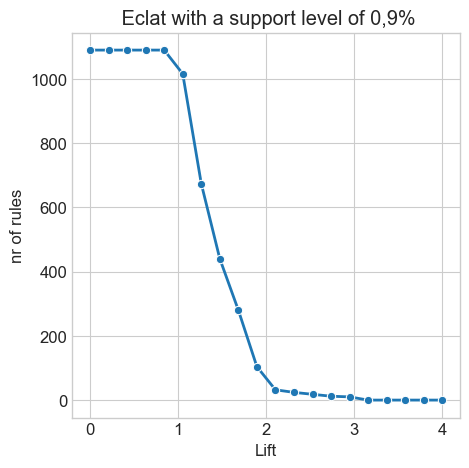

In [357]:
rules_plot_lift = []
for conf in np.linspace(0, 4, 20):
    rules = association_rules(items_ec, metric="lift", min_threshold=conf)
    rules_plot_lift.append(len(rules))
dependence_rules(rules_plot_lift, 'Lift', 'Eclat')    

### Формування та візуалізація правил

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\1096723312.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



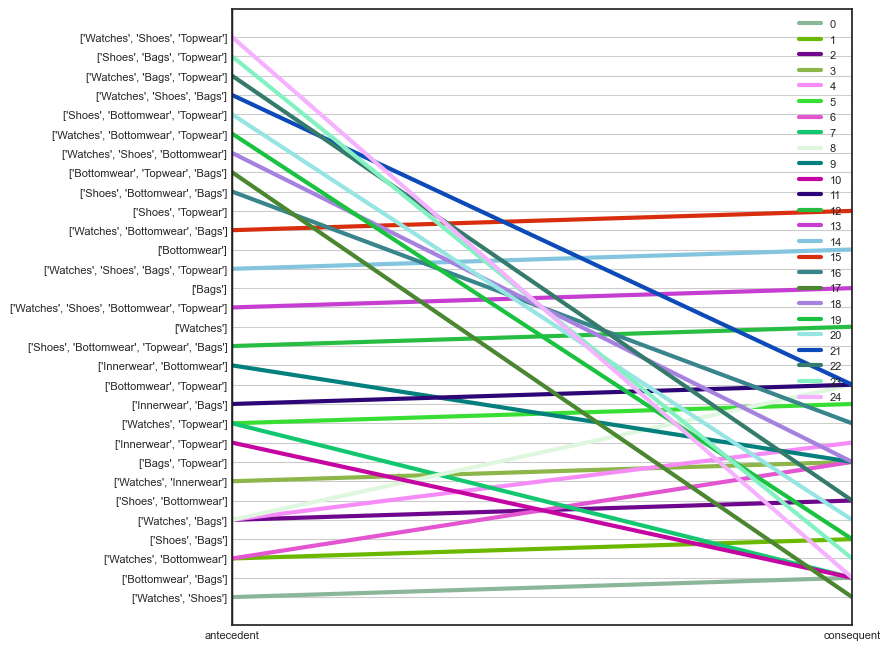

In [358]:
rules_eclat=association_rules(items_ec, metric='lift', min_threshold=2)
rules_eclat['pair'] = list(zip(rules_eclat['antecedents'], rules_eclat['consequents']))
rules_eclat['pair'] = rules_eclat['pair'].apply(frozenset)
rules_eclat.drop_duplicates(subset=['pair'], keep='first', inplace=True)
rules_eclat.reset_index(drop=True, inplace=True)

rules_eclat["antecedent_len"] = rules_eclat["antecedents"].apply(lambda x: len(x))
rules_eclat["consequent_len"] = rules_eclat["consequents"].apply(lambda x: len(x))
rules_eclat['rule'] = rules_eclat.index
rules_eclat.drop(['antecedent support','consequent support','conviction', 'zhangs_metric', 'pair'],axis=1)

line_plt(rules_eclat)

C:\Users\Kira\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



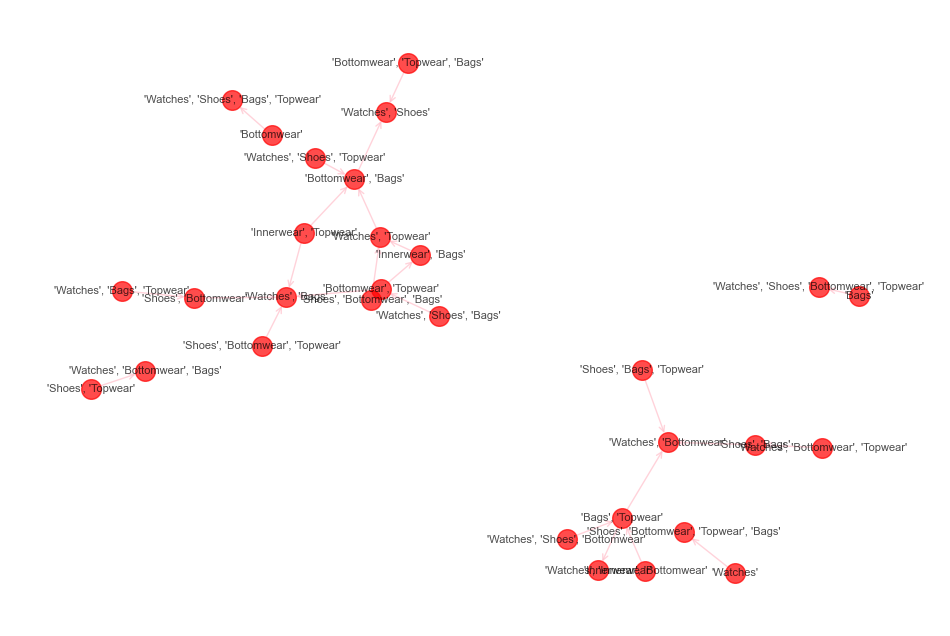

In [359]:
G = nx.from_pandas_edgelist(rules_eclat, source='antecedent', target='consequent')
plt.figure(figsize=(12, 8)) 

node_labels = {node: remove_brackets(node) for node in G.nodes()}
nx.draw_networkx(G, nx.spring_layout(G, k=0.3), arrows=True, arrowstyle='<-', labels=node_labels, cmap='cividis', alpha=0.7, 
                 edge_color='pink',  font_size=8,  node_color='red',  node_size=200)

plt.axis('off')
plt.show()

### Формування датасету для fpgrowth

In [360]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_fp = pd.DataFrame(te_ary, columns=te.columns_)
df_fp

,Accessories,Apparel Set,Bags,Bath and Body,Beauty Accessories,Belts,Bottomwear,Cufflinks,Dress,Eyes,...,Sports Equipment,Stoles,Ties,Topwear,Umbrellas,Vouchers,Wallets,Watches,Water Bottle,Wristbands
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139655,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
139656,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
139657,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
139658,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False


In [361]:
fpg_df = df.groupby(['transactions', 'product_сategory'])['quantity'].sum()
fpg_df = fpg_df.unstack().reset_index()
fpg_df = fpg_df.fillna(0).astype('int32')
fpg_df = fpg_df.set_index('transactions')
fpg_df = fpg_df.applymap(hot_encode)
fpg_df.head()

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\253106702.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



product_сategory,Accessories,Apparel Set,Bags,Bath and Body,Beauty Accessories,Belts,Bottomwear,Cufflinks,Dress,Eyes,...,Sports Equipment,Stoles,Ties,Topwear,Umbrellas,Vouchers,Wallets,Watches,Water Bottle,Wristbands
transactions,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [362]:
from mlxtend.frequent_patterns import fpgrowth

In [363]:
fpg_itemsets = fpgrowth(fpg_df, min_support = 0.009, use_colnames = True)
fpg_itemsets

,support,itemsets
0,0.710683,(Topwear)
1,0.444959,(Shoes)
2,0.057719,(Socks)
3,0.221459,(Bags)
4,0.084842,(Eyewear)
...,...,...
221,0.019061,"(Nails, Topwear)"
222,0.013375,"(Shoes, Nails)"
223,0.010182,"(Shoes, Nails, Topwear)"
224,0.014922,"(Ties, Topwear)"


C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\675168640.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Kira\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\K

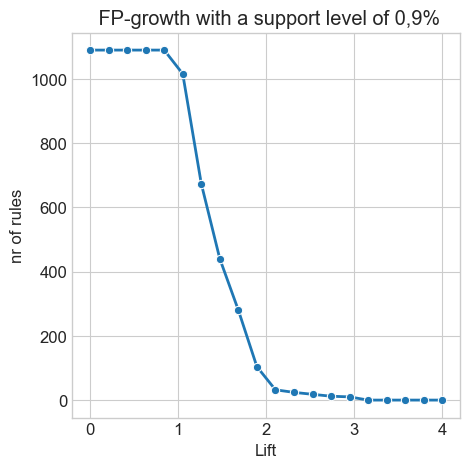

In [364]:
import seaborn as sns
rules_plot_lift = []
for conf in np.linspace(0,4,20):
    rules = association_rules(fpg_itemsets, metric="lift", min_threshold=conf)
    rules_plot_lift.append(len(rules))
dependence_rules(rules_plot_lift, 'Lift', 'FP-growth')  


### Створення та візуалізація правил

C:\Users\Kira\AppData\Local\Temp\ipykernel_11656\1096723312.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



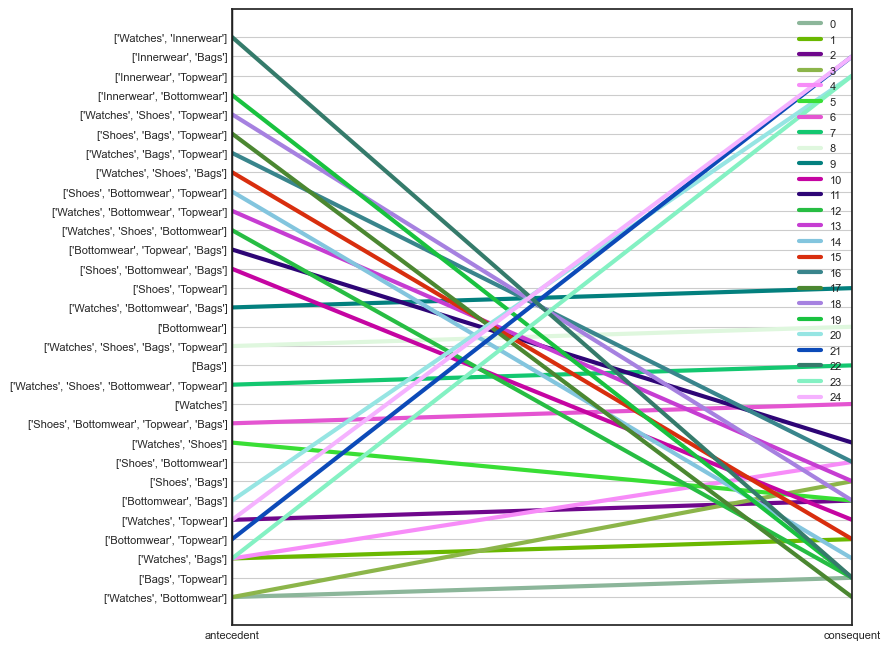

In [365]:
rules_fpg=association_rules(fpg_itemsets, metric='lift', min_threshold=2)

rules_fpg['pair'] = list(zip(rules_fpg['antecedents'], rules_fpg['consequents']))
rules_fpg['pair'] = rules_fpg['pair'].apply(frozenset)
rules_fpg.drop_duplicates(subset=['pair'], keep='first', inplace=True)
rules_fpg.reset_index(drop=True, inplace=True)

rules_fpg["antecedent_len"] = rules_fpg["antecedents"].apply(lambda x: len(x))
rules_fpg["consequent_len"] = rules_fpg["consequents"].apply(lambda x: len(x))
rules_fpg['rule'] = rules_fpg.index
rules_fpg.drop(['antecedent support','consequent support','conviction', 'zhangs_metric', 'pair'],axis=1)
line_plt(rules_fpg)

C:\Users\Kira\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



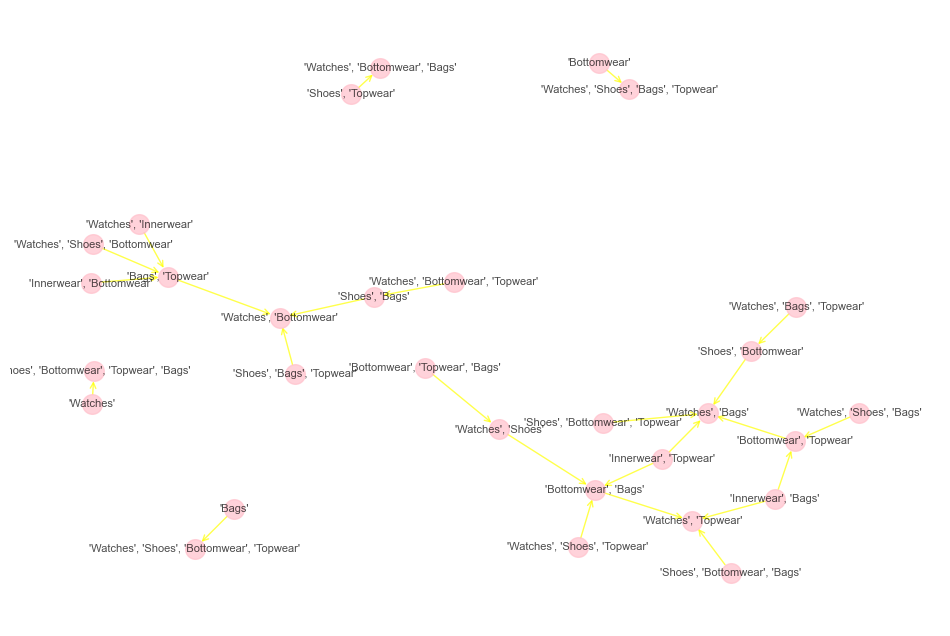

In [366]:
G = nx.from_pandas_edgelist(rules_fpg, source='antecedent', target='consequent')
plt.figure(figsize=(12, 8))

def remove_brackets(label):
    return ', '.join(label[1:-1].split(', '))

node_labels = {node: remove_brackets(node) for node in G.nodes()}
nx.draw_networkx(G, nx.spring_layout(G, k=0.3), arrows=True, arrowstyle='<-', labels=node_labels, cmap='cividis', alpha=0.7, 
                 edge_color='yellow',  font_size=8,  node_color='pink',  node_size=200)

plt.axis('off') 
plt.show()

### Вивід найвищих значень підтримки для всіх алгоритмів

In [367]:
results = []
for df in [apriori_items, items_ec, fpg_itemsets]:
    df_sorted = df.sort_values(by='itemsets')
    first_row = df_sorted.head(1)
    results.append(first_row)
results

[    support       itemsets
 0  0.011786  (Accessories),
     support      itemsets
 0  0.073636  (Flip Flops),
     support   itemsets
 0  0.710683  (Topwear)]